In [37]:
#Import libraries to start data exploration/visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [38]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [39]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [40]:
#Convert total charges from object to float
df.TotalCharges = pd.to_numeric(df.TotalCharges, errors='coerce')

In [41]:
#Start by getting a sense of our already numeric data
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7032.000000
mean,0.162147,32.371149,64.761692,2283.300441
std,0.368612,24.559481,30.090047,2266.771362
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


C:\Users\charl\anaconda3\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  if __name__ == '__main__':


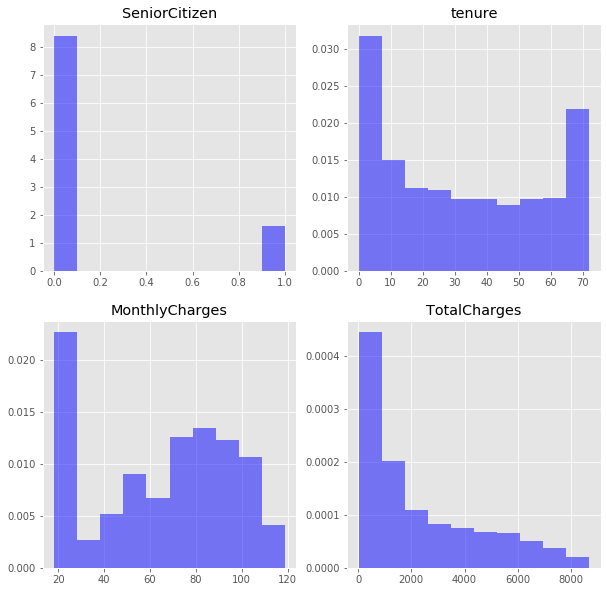

In [48]:
#Create a list of our numeric variables
hists = ['SeniorCitizen','tenure','MonthlyCharges','TotalCharges']

#create figure for our histograms
fig = plt.figure(figsize=(10,10))

for idx, val in enumerate(hists):
    plt.subplot(2,2,idx+1)
    plt.hist(val, data = df, normed = True, alpha = 0.5, color = 'blue')
    plt.title(val)

Insights from hists:
1) About 25% of customers are taking the lowest possible plan availble

In [89]:
#Find churn percentage
pt_churn = len(df.loc[df.Churn == 'Yes'])/len(df)
pt_stay = 1 - pt_churn
print(pt_churn)

0.2653698707936959


Text(0.5, 1.0, 'Likelihood to Churn')

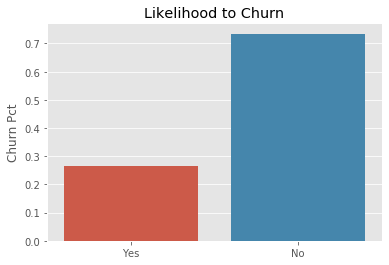

In [95]:
#Graph Churn
sns.barplot(y = [pt_churn,pt_stay], x = ['Yes','No'])
plt.ylabel('Churn Pct')
plt.title('Likelihood to Churn')

0.7346301292063041

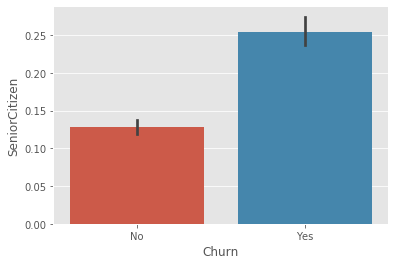

In [81]:
sns.barplot('Churn','SeniorCitizen',data=df)
#I don't understand why these would not add up to 100%? or why not to the mean churn pct
